# Grok銘柄マーケット相関分析
## 目的: マーケット環境・スコアとパフォーマンスの関係を可視化

- 先物（日経225先物）との相関
- 為替（USD/JPY, EUR/JPY）との相関
- 指数・ETF（TOPIX、プライム、グロースなど）との相関
- selection_scoreと勝率・リターンの関係
- スコアとマーケット指標の相関

In [12]:
import sys
from pathlib import Path

# grok_trending_performance ディレクトリ
GROK_DIR = Path.cwd().parent
SCRIPTS_DIR = GROK_DIR / 'scripts'

if str(SCRIPTS_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPTS_DIR))

# プロジェクトルート（dash_plotly）
ROOT = GROK_DIR.parent.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 日本語フォント設定を最優先で適用
matplotlib.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Hiragino Kaku Gothic ProN', 'Yu Gothic', 'Meiryo', 'DejaVu Sans']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# matplotlibのフォントキャッシュをクリア
fm._load_fontmanager(try_read_cache=False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

from load_data import DataLoader

loader = DataLoader()
print("✓ ライブラリ読み込み完了")
print(f"✓ 使用フォント: {plt.rcParams['font.sans-serif'][0]}")

✓ ライブラリ読み込み完了
✓ 使用フォント: Arial


## 1. データ読み込み

In [13]:
# Grokバックテストアーカイブ
archive = loader.load_grok_archive()

print(f"総レコード数: {len(archive)}")
print(f"期間: {archive['backtest_date'].min()} ～ {archive['backtest_date'].max()}")
print(f"\n【カラム】")
print(archive.columns.tolist())

# 日付を統一
archive['date'] = pd.to_datetime(archive['backtest_date']).dt.date
archive['return_pct'] = archive['phase1_return'] * 100

archive.head(3)

✓ Grok archive loaded: 24 records
総レコード数: 24
期間: 2025-10-28 00:00:00 ～ 2025-10-30 00:00:00

【カラム】
['ticker', 'stock_name', 'selection_score', 'grok_rank', 'reason', 'selected_time', 'backtest_date', 'buy_price', 'sell_price', 'phase1_return', 'phase1_win', 'prompt_version', 'profit_per_100_shares', 'morning_high', 'morning_low', 'morning_volume', 'max_gain_pct', 'max_drawdown_pct']


,ticker,stock_name,selection_score,grok_rank,reason,selected_time,backtest_date,buy_price,sell_price,phase1_return,phase1_win,prompt_version,profit_per_100_shares,morning_high,morning_low,morning_volume,max_gain_pct,max_drawdown_pct,date,return_pct
0,4592.T,サンバイオ,160.0,1,2025年10月29日夜に再生医療分野での治験進展ニュースが報道。Xで「2025年10月30...,23:00,2025-10-30,2720.0,2782.0,0.022794,True,v1_0_baseline,6200.0,2792.0,2709.0,571800.0,0.028740,-0.001842,2025-10-30,2.279412
1,3914.T,JIG-SAW,158.0,2,2025年10月29日引け後にAI関連の新サービス開始をIR発表。Xで「2025年10月30...,23:00,2025-10-30,3350.0,3500.0,0.044776,True,v1_0_baseline,15000.0,3500.0,3215.0,71200.0,0.043219,-0.041729,2025-10-30,4.477612
2,4575.T,キャンバス,155.0,3,2025年10月29日夜に抗がん剤開発の進展ニュースが報道。Xで「2025年10月30日仕込...,23:00,2025-10-30,856.0,856.0,0.000000,False,v1_0_baseline,0.0,871.0,850.0,118300.0,0.018713,-0.005848,2025-10-30,0.000000


## 2. マーケットデータ読み込み

In [14]:
# 指数・ETF（1日足）
index_prices = loader.load_index_prices('1d')
index_prices['date'] = pd.to_datetime(index_prices['date']).dt.date

# 先物（1日足）
futures_prices = loader.load_futures_prices('1d')
futures_prices['date'] = pd.to_datetime(futures_prices['date']).dt.date

# 為替（1日足）
currency_prices = loader.load_currency_prices('1d')
currency_prices['date'] = pd.to_datetime(currency_prices['date']).dt.date

print("【指数・ETF】")
print(f"  ティッカー: {index_prices['ticker'].unique()}")
print(f"\n【先物】")
print(f"  ティッカー: {futures_prices['ticker'].unique()}")
print(f"\n【為替】")
print(f"  ティッカー: {currency_prices['ticker'].unique()}")

✓ Index prices loaded: 149770 rows, interval=1d
✓ Futures prices loaded: 5465 rows, interval=1d
✓ Currency prices loaded: 15052 rows, interval=1d
【指数・ETF】
  ティッカー: ['1489.T' '1591.T' '2516.T' '1570.T' '1306.T' '1311.T' '^N225' '1357.T'
 '1563.T' '1554.T']

【先物】
  ティッカー: ['NKD=F']

【為替】
  ティッカー: ['EURJPY=X' 'JPY=X']


## 3. 日次リターン計算

In [15]:
# 各マーケット指標の日次リターンを計算
market_returns = {}

# 指数・ETF
for ticker in index_prices['ticker'].unique():
    df = index_prices[index_prices['ticker'] == ticker].copy()
    df = df.sort_values('date')
    df['return'] = df['Close'].pct_change(fill_method=None) * 100
    market_returns[ticker] = df[['date', 'return']].rename(columns={'return': ticker})

# 先物
for ticker in futures_prices['ticker'].unique():
    df = futures_prices[futures_prices['ticker'] == ticker].copy()
    df = df.sort_values('date')
    df['return'] = df['Close'].pct_change(fill_method=None) * 100
    market_returns[ticker] = df[['date', 'return']].rename(columns={'return': ticker})

# 為替
for ticker in currency_prices['ticker'].unique():
    df = currency_prices[currency_prices['ticker'] == ticker].copy()
    df = df.sort_values('date')
    df['return'] = df['Close'].pct_change(fill_method=None) * 100
    market_returns[ticker] = df[['date', 'return']].rename(columns={'return': ticker})

print(f"✓ {len(market_returns)} 指標のリターンを計算")

✓ 13 指標のリターンを計算


## 4. Grok銘柄とマーケット指標の結合

In [16]:
# すべてのマーケット指標を1つのDataFrameに結合
merged = archive[['date', 'ticker', 'stock_name', 'selection_score', 'return_pct', 'phase1_win']].copy()

for ticker_name, df in market_returns.items():
    merged = merged.merge(df, on='date', how='left')

print(f"結合後のカラム: {merged.columns.tolist()}")
print(f"\nデータ数: {len(merged)}")
print(f"\nサンプル:")
merged.head(3)

結合後のカラム: ['date', 'ticker', 'stock_name', 'selection_score', 'return_pct', 'phase1_win', '1489.T', '1591.T', '2516.T', '1570.T', '1306.T', '1311.T', '^N225', '1357.T', '1563.T', '1554.T', 'NKD=F', 'EURJPY=X', 'JPY=X']

データ数: 24

サンプル:


,date,ticker,stock_name,selection_score,return_pct,phase1_win,1489.T,1591.T,2516.T,1570.T,1306.T,1311.T,^N225,1357.T,1563.T,1554.T,NKD=F,EURJPY=X,JPY=X
0,2025-10-30,4592.T,サンバイオ,160.0,2.279412,True,0.974659,-0.067114,1.266052,-0.330761,0.581734,0.056275,0.035006,0.314191,-0.738689,0.257688,0.400391,0.188273,0.653128
1,2025-10-30,3914.T,JIG-SAW,158.0,4.477612,True,0.974659,-0.067114,1.266052,-0.330761,0.581734,0.056275,0.035006,0.314191,-0.738689,0.257688,0.400391,0.188273,0.653128
2,2025-10-30,4575.T,キャンバス,155.0,0.000000,False,0.974659,-0.067114,1.266052,-0.330761,0.581734,0.056275,0.035006,0.314191,-0.738689,0.257688,0.400391,0.188273,0.653128


## 5. 相関係数計算

In [17]:
# Grokリターンとマーケット指標の相関
market_cols = [col for col in merged.columns if col not in ['date', 'ticker', 'stock_name', 'selection_score', 'return_pct', 'phase1_win']]

correlations = {}
sample_counts = {}
for col in market_cols:
    valid_data = merged[['return_pct', col]].dropna()
    if len(valid_data) > 0:
        corr = valid_data['return_pct'].corr(valid_data[col])
        correlations[col] = corr
        sample_counts[col] = len(valid_data)

# 相関係数をDataFrameに
corr_df = pd.DataFrame({
    '指標': list(correlations.keys()),
    '相関係数': list(correlations.values()),
    'サンプル数': [sample_counts[k] for k in correlations.keys()]
})
corr_df = corr_df.sort_values('相関係数', ascending=False)

print("【Grokリターンとマーケット指標の相関】")
print(f"⚠️ 注意: Grokデータが{len(archive)}件（{archive['date'].nunique()}日分）のため、相関係数の信頼性は限定的です")
print(corr_df.round(3))

# サンプル数が少ない警告
if archive['date'].nunique() < 10:
    print(f"\n⚠️ 警告: データが{archive['date'].nunique()}営業日分しかありません。")
    print("   相関分析には最低でも20-30営業日以上のデータが推奨されます。")

【Grokリターンとマーケット指標の相関】
⚠️ 注意: Grokデータが24件（2日分）のため、相関係数の信頼性は限定的です
          指標   相関係数  サンプル数
9     1554.T  0.458     23
2     2516.T  0.458     23
11  EURJPY=X  0.458     23
0     1489.T  0.458     23
1     1591.T  0.458     23
8     1563.T  0.458     23
3     1570.T  0.458     23
6      ^N225  0.458     23
5     1311.T  0.458     23
4     1306.T  0.458     23
12     JPY=X  0.458     23
7     1357.T -0.458     23
10     NKD=F -0.458     23

⚠️ 警告: データが2営業日分しかありません。
   相関分析には最低でも20-30営業日以上のデータが推奨されます。


## 6. 相関ヒートマップ

/Users/hiroyukiyamanaka/.pyenv/versions/3.12.3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/hiroyukiyamanaka/.pyenv/versions/3.12.3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/hiroyukiyamanaka/.pyenv/versions/3.12.3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/hiroyukiyamanaka/.pyenv/versions/3.12.3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/hiroyukiyamanaka/.pyenv/versions/3.12.3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) Arial.
  fig.canvas.draw()
/Users

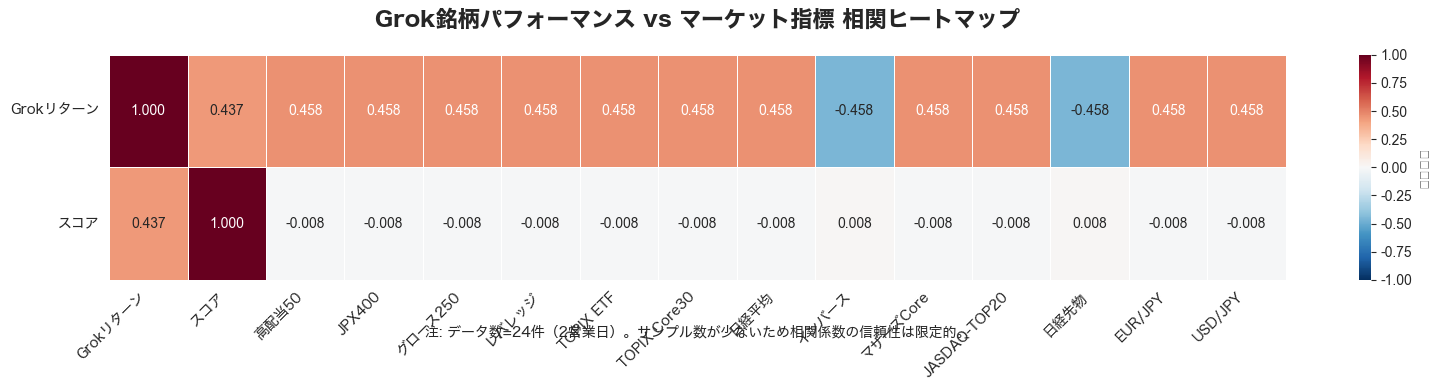

✓ ヒートマップ保存完了: outputs/figures/grok_correlation_heatmap.png
✓ データ期間: 2営業日分


In [18]:
# 相関マトリックス作成（Grokリターンとスコアに焦点）
correlation_cols = ['return_pct', 'selection_score'] + market_cols
corr_matrix = merged[correlation_cols].corr()

# ラベル名を整理
label_mapping = {
    'return_pct': 'Grokリターン',
    'selection_score': 'スコア',
    '^N225': '日経平均',
    'NKD=F': '日経先物',
    'JPY=X': 'USD/JPY',
    'EURJPY=X': 'EUR/JPY',
    '1306.T': 'TOPIX ETF',
    '1311.T': 'TOPIX Core30',
    '1591.T': 'JPX400',
    '1489.T': '高配当50',
    '2516.T': 'グロース250',
    '1563.T': 'マザーズCore',
    '1554.T': 'JASDAQ-TOP20',
    '1570.T': 'レバレッジ',
    '1357.T': 'インバース',
}

corr_matrix_renamed = corr_matrix.rename(index=label_mapping, columns=label_mapping)

# Grokリターンとスコアの行のみ抽出（見やすくするため）
focus_rows = ['Grokリターン', 'スコア']
corr_focused = corr_matrix_renamed.loc[focus_rows, :]

# ヒートマップ描画（横長）
fig, ax = plt.subplots(figsize=(16, 4))
sns.heatmap(corr_focused, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={'label': '相関係数'},
            ax=ax)

ax.set_title('Grok銘柄パフォーマンス vs マーケット指標 相関ヒートマップ', 
             fontsize=16, fontweight='bold', fontfamily='Hiragino Sans', pad=20)

# 軸ラベルのフォント設定
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='Hiragino Sans', rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), fontfamily='Hiragino Sans', rotation=0)

# データ数の注釈を追加
ax.text(0.5, -0.25, f'注: データ数={len(archive)}件（{archive["date"].nunique()}営業日）。サンプル数が少ないため相関係数の信頼性は限定的。', 
        transform=ax.transAxes, ha='center', fontsize=10, fontfamily='Hiragino Sans', style='italic')

plt.tight_layout()
plt.savefig('../outputs/figures/grok_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ ヒートマップ保存完了: outputs/figures/grok_correlation_heatmap.png")
print(f"✓ データ期間: {archive['date'].nunique()}営業日分")

## 7. スコアと勝率・リターンの関係

【スコア分位別パフォーマンス】
                平均リターン(%)  勝率(%)  リターン標準偏差  件数
score_quintile                                
Q1(低)               -0.44   40.0      0.85   5
Q2                   0.06   40.0      0.80   4
Q3                  -0.88   25.0      1.71   4
Q4                   0.29   50.0      1.25   6
Q5(高)                1.57   50.0      2.28   4


/var/folders/lc/9gc67bcn35g9t21r_pbch1t80000gn/T/ipykernel_12644/1168256227.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_perf = archive_score.groupby('score_quintile').agg({


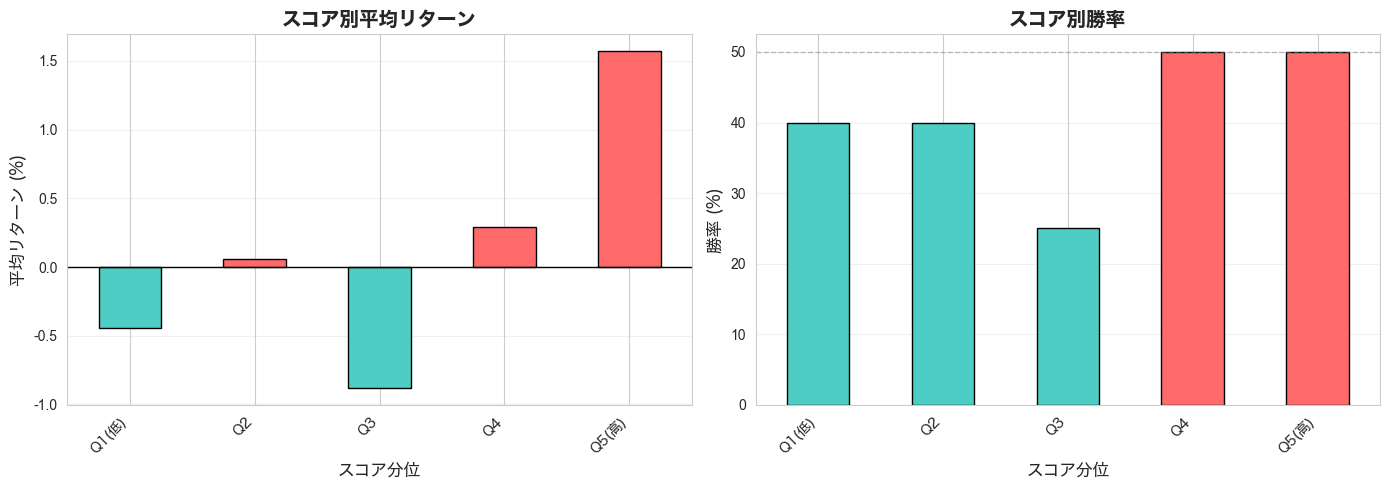

✓ グラフ保存完了: outputs/figures/grok_score_performance.png


In [19]:
# スコアを5分位に分割
archive_score = archive.copy()
archive_score['score_quintile'] = pd.qcut(archive_score['selection_score'], q=5, labels=['Q1(低)', 'Q2', 'Q3', 'Q4', 'Q5(高)'], duplicates='drop')

# スコア分位別の統計
score_perf = archive_score.groupby('score_quintile').agg({
    'return_pct': ['mean', 'std', 'count'],
    'phase1_win': lambda x: (x == True).mean()
}).round(2)

score_perf.columns = ['平均リターン(%)', 'リターン標準偏差', '件数', '勝率']
score_perf['勝率(%)'] = (score_perf['勝率'] * 100).round(1)
score_perf = score_perf[['平均リターン(%)', '勝率(%)', 'リターン標準偏差', '件数']]

print("【スコア分位別パフォーマンス】")
print(score_perf)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 平均リターン
ax1 = axes[0]
colors = ['#FF6B6B' if x > 0 else '#4ECDC4' for x in score_perf['平均リターン(%)']]
score_perf['平均リターン(%)'].plot(kind='bar', ax=ax1, color=colors, edgecolor='black')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.set_ylabel('平均リターン (%)', fontsize=12, fontfamily='Hiragino Sans')
ax1.set_xlabel('スコア分位', fontsize=12, fontfamily='Hiragino Sans')
ax1.set_title('スコア別平均リターン', fontsize=14, fontweight='bold', fontfamily='Hiragino Sans')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), fontfamily='Hiragino Sans', rotation=45, ha='right')

# 勝率
ax2 = axes[1]
colors = ['#FF6B6B' if x >= 50 else '#4ECDC4' for x in score_perf['勝率(%)']]
score_perf['勝率(%)'].plot(kind='bar', ax=ax2, color=colors, edgecolor='black')
ax2.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_ylabel('勝率 (%)', fontsize=12, fontfamily='Hiragino Sans')
ax2.set_xlabel('スコア分位', fontsize=12, fontfamily='Hiragino Sans')
ax2.set_title('スコア別勝率', fontsize=14, fontweight='bold', fontfamily='Hiragino Sans')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticklabels(ax2.get_xticklabels(), fontfamily='Hiragino Sans', rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../outputs/figures/grok_score_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ グラフ保存完了: outputs/figures/grok_score_performance.png")

## 8. スコアとマーケット指標の相関

/var/folders/lc/9gc67bcn35g9t21r_pbch1t80000gn/T/ipykernel_12644/517897781.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontfamily='Hiragino Sans')


【スコアとマーケット指標の相関】
          指標   相関係数
10     NKD=F  0.008
7     1357.T  0.008
8     1563.T -0.008
0     1489.T -0.008
3     1570.T -0.008
6      ^N225 -0.008
9     1554.T -0.008
11  EURJPY=X -0.008
2     2516.T -0.008
4     1306.T -0.008
5     1311.T -0.008
12     JPY=X -0.008
1     1591.T -0.008


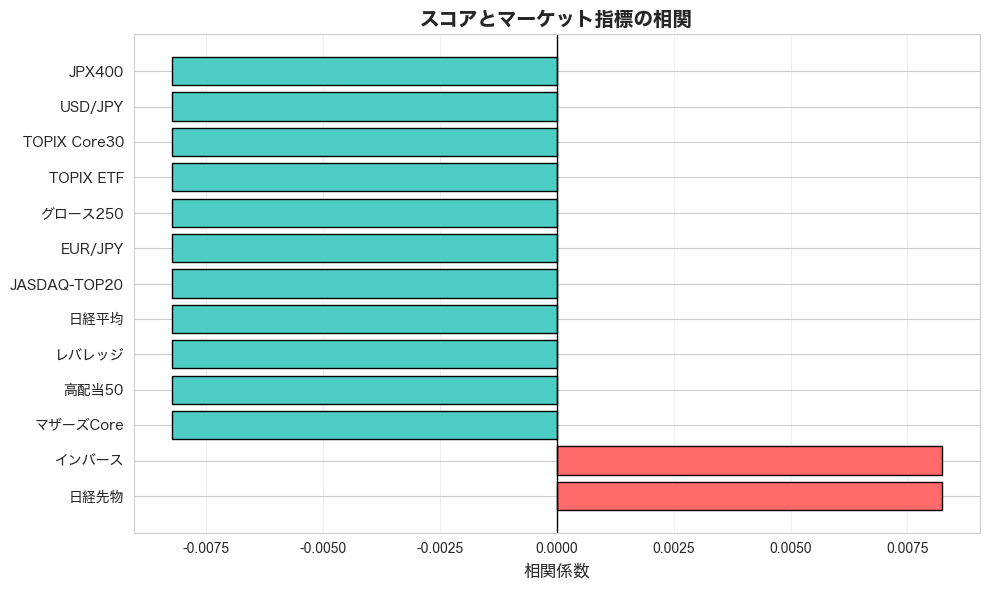

✓ グラフ保存完了: outputs/figures/grok_score_market_correlation.png


In [20]:
# スコアとマーケット指標の相関
score_correlations = {}
for col in market_cols:
    valid_data = merged[['selection_score', col]].dropna()
    if len(valid_data) > 0:
        corr = valid_data['selection_score'].corr(valid_data[col])
        score_correlations[col] = corr

score_corr_df = pd.DataFrame(list(score_correlations.items()), columns=['指標', '相関係数'])
score_corr_df = score_corr_df.sort_values('相関係数', ascending=False)

print("【スコアとマーケット指標の相関】")
print(score_corr_df.round(3))

# 可視化
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#FF6B6B' if x > 0 else '#4ECDC4' for x in score_corr_df['相関係数']]
score_corr_df_renamed = score_corr_df.copy()
score_corr_df_renamed['指標'] = score_corr_df_renamed['指標'].map(label_mapping).fillna(score_corr_df_renamed['指標'])

ax.barh(score_corr_df_renamed['指標'], score_corr_df_renamed['相関係数'], color=colors, edgecolor='black')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('相関係数', fontsize=12, fontfamily='Hiragino Sans')
ax.set_title('スコアとマーケット指標の相関', fontsize=14, fontweight='bold', fontfamily='Hiragino Sans')
ax.grid(True, alpha=0.3, axis='x')
ax.set_yticklabels(ax.get_yticklabels(), fontfamily='Hiragino Sans')

plt.tight_layout()
plt.savefig('../outputs/figures/grok_score_market_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ グラフ保存完了: outputs/figures/grok_score_market_correlation.png")

## 9. トップ相関指標との散布図

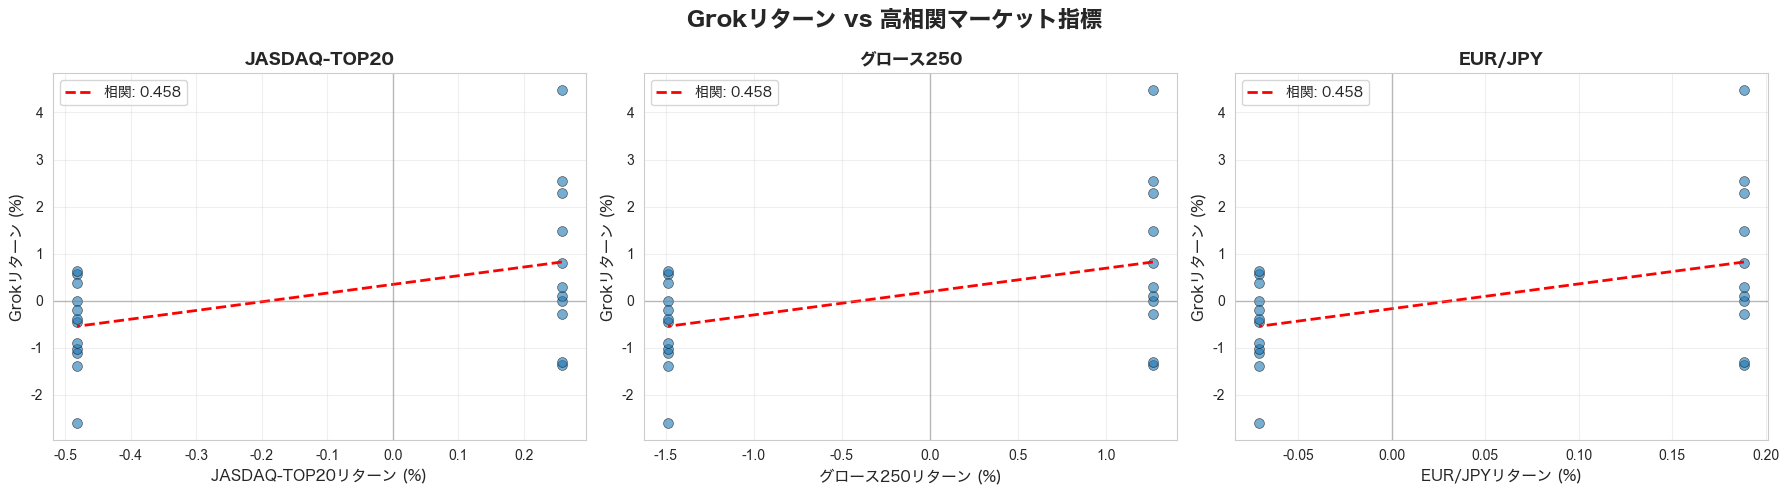

✓ グラフ保存完了: outputs/figures/grok_top_correlation_scatter.png


In [21]:
# 上位3つの相関が高い指標
top3_corr = corr_df.head(3)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Grokリターン vs 高相関マーケット指標', fontsize=16, fontweight='bold', fontfamily='Hiragino Sans')

for idx, (_, row) in enumerate(top3_corr.iterrows()):
    indicator = row['指標']
    corr_val = row['相関係数']
    
    ax = axes[idx]
    valid_data = merged[['return_pct', indicator]].dropna()
    
    if len(valid_data) > 0:
        ax.scatter(valid_data[indicator], valid_data['return_pct'], 
                  alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        # 回帰線
        z = np.polyfit(valid_data[indicator], valid_data['return_pct'], 1)
        p = np.poly1d(z)
        ax.plot(valid_data[indicator], p(valid_data[indicator]), 
               "r--", linewidth=2, label=f'相関: {corr_val:.3f}')
        
        ax.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
        
        indicator_label = label_mapping.get(indicator, indicator)
        ax.set_xlabel(f'{indicator_label}リターン (%)', fontsize=11, fontfamily='Hiragino Sans')
        ax.set_ylabel('Grokリターン (%)', fontsize=11, fontfamily='Hiragino Sans')
        ax.set_title(f'{indicator_label}', fontsize=12, fontweight='bold', fontfamily='Hiragino Sans')
        ax.legend(fontsize=10, prop={'family': 'Hiragino Sans'})
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/grok_top_correlation_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ グラフ保存完了: outputs/figures/grok_top_correlation_scatter.png")

## 10. レポート出力

In [22]:
# 相関レポート保存
corr_df.to_csv('../outputs/reports/grok_market_correlations.csv', index=False)
score_corr_df.to_csv('../outputs/reports/grok_score_correlations.csv', index=False)
score_perf.to_csv('../outputs/reports/grok_score_performance.csv')

print("✓ レポート保存完了:")
print("  - outputs/reports/grok_market_correlations.csv")
print("  - outputs/reports/grok_score_correlations.csv")
print("  - outputs/reports/grok_score_performance.csv")
print("\n✓ グラフ保存完了:")
print("  - outputs/figures/grok_correlation_heatmap.png")
print("  - outputs/figures/grok_score_performance.png")
print("  - outputs/figures/grok_score_market_correlation.png")
print("  - outputs/figures/grok_top_correlation_scatter.png")

✓ レポート保存完了:
  - outputs/reports/grok_market_correlations.csv
  - outputs/reports/grok_score_correlations.csv
  - outputs/reports/grok_score_performance.csv

✓ グラフ保存完了:
  - outputs/figures/grok_correlation_heatmap.png
  - outputs/figures/grok_score_performance.png
  - outputs/figures/grok_score_market_correlation.png
  - outputs/figures/grok_top_correlation_scatter.png
